In [117]:
import json
import sys
import os
# Add the parent directory of the notebook to the path
sys.path.append(os.path.abspath("../.."))
from utils import apply_nature_axis_style
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec


### Hand Writing Convertors

In [118]:
QE_array = {
    "train_sizes": [43,130,302,432],
    "model_order": ["SSL","Nominal","Ablation","Scratch"],
    "values": {
        43:  ({"SSL":218,"Nominal":198,"Ablation":150,"Scratch":144},
              {"SSL":1.20,"Nominal":0.88,"Ablation":0.92,"Scratch":1.27}),
        130: ({"SSL":280,"Nominal":98,"Ablation":67,"Scratch":107},
              {"SSL":1.06,"Nominal":0.87,"Ablation":0.89,"Scratch":1.13}),
        302: ({"SSL":168,"Nominal":93,"Ablation":56,"Scratch":85},
              {"SSL":1.00,"Nominal":0.87,"Ablation":0.88,"Scratch":1.05}),
        432: ({"SSL":200,"Nominal":74,"Ablation":71,"Scratch":87},
              {"SSL":0.98,"Nominal":0.86,"Ablation":0.88,"Scratch":1.02}),
    }
}
DeltaD_DATA = {
    43:  {"SSL":1.91, "Nominal":1.21, "Ablation":1.24, "Scratch":1.89, "Ref.":5.26},
    130: {"SSL":1.48, "Nominal":1.20, "Ablation":1.23, "Scratch":1.54, "Ref.":5.26},
    302: {"SSL":1.40, "Nominal":1.20, "Ablation":1.23, "Scratch":1.45, "Ref.":5.26},
    432: {"SSL":1.37, "Nominal":1.21, "Ablation":1.24, "Scratch":1.37, "Ref.":5.26},
}
QE_DATA = {
    43:  {"SSL":49.53, "Nominal":81.74, "Ablation":81.48, "Scratch":45.64, "Ref.":None},
    130: {"SSL":79.15, "Nominal":81.91, "Ablation":81.51, "Scratch":77.00, "Ref.":None},
    302: {"SSL":80.37, "Nominal":82.29, "Ablation":81.69, "Scratch":78.85, "Ref.":None},
    432: {"SSL":80.83, "Nominal":82.17, "Ablation":81.95, "Scratch":80.48, "Ref.":None},
}

In [119]:
models = QE_array["model_order"]
final_metrics = dict()

final_metrics["pairing"] = QE_DATA
final_metrics["deltaD"] = DeltaD_DATA
final_metrics["epoch"] = {
    dataset_size: metrics[0]
    for dataset_size, metrics in QE_array["values"].items()
}
final_metrics["effective_step"] = {
    dataset_size:  {model: int(epoch* float(dataset_size) * 1000 / (1024 * 16)) for model, epoch in metrics[0].items()}
    for dataset_size, metrics in QE_array["values"].items()
}
final_metrics["val_loss"] = {
    dataset_size: metrics[1]
    for dataset_size, metrics in QE_array["values"].items()
}
final_metrics["model_order"] = QE_array["model_order"]
final_metrics["train_sizes"] = QE_array["train_sizes"]
with open("data/QE_result.json", "w") as f:
    json.dump(final_metrics, f)

In [120]:
### Plotting function

In [121]:
with open("data/QE_result.json", 'r') as f:
    data = json.load(f)


In [122]:
import seaborn as sns
import numpy as np

# -----------------------------------------------------------
# Colors (same style as your main plot)
# -----------------------------------------------------------
greens = sns.color_palette("Greens", 12)
blues  = sns.color_palette("Blues", 12)

MODEL_COLORS = {
    "SSL":              greens[3],
    "Nominal":          greens[9],
    "Scratch":          blues[8],
    "Ref.": "#7f7f7f",
}

DATASET_MARKERS = {
    '43':  "o",
    '130': "s",
    '302': "D",
    '432': "^",
}

QE_PRETTY = {
    "SSL":     "SSL",
    "Nominal": "Nominal",
    "Ablation":"Ablation",
    "Scratch": "Scratch",
    "Ref.":    "Ref"
}

In [123]:
data

{'pairing': {'43': {'SSL': 49.53,
   'Nominal': 81.74,
   'Ablation': 81.48,
   'Scratch': 45.64,
   'Ref.': None},
  '130': {'SSL': 79.15,
   'Nominal': 81.91,
   'Ablation': 81.51,
   'Scratch': 77.0,
   'Ref.': None},
  '302': {'SSL': 80.37,
   'Nominal': 82.29,
   'Ablation': 81.69,
   'Scratch': 78.85,
   'Ref.': None},
  '432': {'SSL': 80.83,
   'Nominal': 82.17,
   'Ablation': 81.95,
   'Scratch': 80.48,
   'Ref.': None}},
 'deltaD': {'43': {'SSL': 1.91,
   'Nominal': 1.21,
   'Ablation': 1.24,
   'Scratch': 1.89,
   'Ref.': 5.26},
  '130': {'SSL': 1.48,
   'Nominal': 1.2,
   'Ablation': 1.23,
   'Scratch': 1.54,
   'Ref.': 5.26},
  '302': {'SSL': 1.4,
   'Nominal': 1.2,
   'Ablation': 1.23,
   'Scratch': 1.45,
   'Ref.': 5.26},
  '432': {'SSL': 1.37,
   'Nominal': 1.21,
   'Ablation': 1.24,
   'Scratch': 1.37,
   'Ref.': 5.26}},
 'epoch': {'43': {'SSL': 218, 'Nominal': 198, 'Ablation': 150, 'Scratch': 144},
  '130': {'SSL': 280, 'Nominal': 98, 'Ablation': 67, 'Scratch': 107},
 

In [124]:
# -----------------------------------------------------------
# MAIN CLEAN FUNCTION
# -----------------------------------------------------------
def plot_QE_single_panel_loss(QE_array,
                              y_label="Val loss",
                              panel_title="Quantum Entanglement (Assg+SG)",
                              ymin=0.8,
                              figsize=(12,6),
                              fname = None,
                              plotdir = "./"
                            ):

    fig, ax = plt.subplots(figsize=figsize)

    train_sizes = QE_array["train_sizes"]
    model_keys  = QE_array["model_order"]

    # -------------------------------------------------------
    # Plot each model
    # -------------------------------------------------------
    for model in model_keys:

        if model not in MODEL_COLORS:
            continue

        xs = []
        ys = []
        markers = []


        
        for ds_k, eff_steps in QE_array["effective_step"].items():
            val = QE_array["val_loss"][ds_k].get(model, None)
            es  = eff_steps.get(model, None)

            if val is None or es is None:
                continue

            

            xs.append(es)
            ys.append(val)
            markers.append(DATASET_MARKERS[ds_k])

        # sort by effective steps
        arr = sorted(zip(xs, ys, markers), key=lambda x: x[0])
        xs, ys, markers = zip(*arr)

        # ---- line ----
        ax.plot(xs, ys,
                color=MODEL_COLORS[model],
                linewidth=2,
                alpha=0.9)

        # ---- points ----
        for x, y, mk in zip(xs, ys, markers):
            ax.scatter(x, y,
                       s=140,
                       marker=mk,
                       color=MODEL_COLORS[model],
                       edgecolor="black",
                       linewidth=0.7)


    # -------------------------------------------------------
    # Axes
    # -------------------------------------------------------
    ax.set_xscale("log")
    ax.set_xlabel("Effective steps", fontsize=16)
    ax.set_ylabel(y_label, fontsize=16)
    ax.set_ylim(bottom=ymin)
    #ax.set_title(panel_title, fontsize=20, weight="bold")

    apply_nature_axis_style(ax)
    ax.tick_params(axis='both', which='major', labelsize=14)


    # -------------------------------------------------------
    # LEGEND 1 — Model Types
    # -------------------------------------------------------
    model_handles = [
        plt.Line2D([0],[0], marker='s',
                    markersize=14,
                    linestyle='',
                    color=MODEL_COLORS[m],
                    markeredgecolor="black",
                    label=m)
        for m in MODEL_COLORS
    ]

    fig.legend(
        [plt.Line2D([],[], linestyle="none", label=r"$\bf{Model\ Types}$")] + model_handles,
        [r"$\bf{Model\ Types}$"] + [m for m in model_keys],
        loc="upper center",
        bbox_to_anchor=(0.5, 1.12),
        ncol=len(model_handles)+1,
        frameon=False,
        fontsize=15,
        handletextpad=0.4,
        columnspacing=1.5
    )

    # -------------------------------------------------------
    # LEGEND 2 — Dataset Sizes
    # -------------------------------------------------------
    ds_handles = [
        plt.Line2D([0],[0],
                   marker=DATASET_MARKERS[str(ds)],
                   markersize=14,
                   linestyle='',
                   color="gray",
                   markeredgecolor="black",
                   label=f"{ds}K")
        for ds in train_sizes
    ]

    fig.legend(
        [plt.Line2D([],[], linestyle="none", label=r"$\bf{Dataset\ Size:}$")] + ds_handles,
        [r"$\bf{Dataset\ Size:}$"] + [f"{ds}K" for ds in train_sizes],
        loc="upper center",
        bbox_to_anchor=(0.5, 1.06),
        ncol=len(ds_handles)+1,
        frameon=False,
        fontsize=15,
        handletextpad=0.4,
        columnspacing=1.5
    )

    plt.tight_layout(rect=[0,0,1,0.95])
    if fname is not None:
        # ---- SAVE HERE ----
        os.makedirs(plotdir, exist_ok=True)
        fig.savefig(os.path.join(plotdir,fname), bbox_inches="tight")
        print(f"Saved figure → {fname}")



Saved figure → loss.pdf


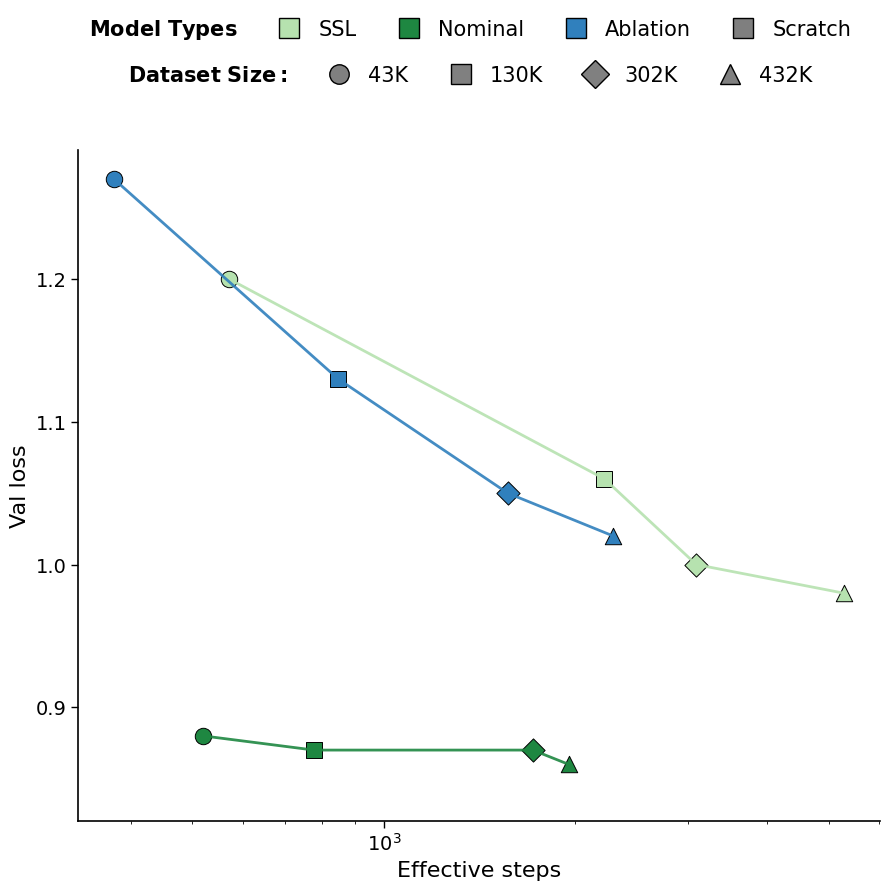

In [125]:
plot_QE_single_panel_loss(data, ymin=0.82, figsize=(9,8), plotdir = "plot/QE", fname="loss.pdf")

In [126]:
# ===========================================
# Tuned QE-style plot
# ===========================================
def plot_two_panel_QE_style(
    data_dict,
    model_order,
    model_colors,
    model_pretty_names,
    y_label="Metric",
    head_label="Assg + SG",
    ymin=0,
    figsize=(14, 6),
    panel_ratio=(3, 2),           # << tunable left:right panel ratio
    bar_width=0.025,              # << slimmer bars
    bar_spacing=0.035,            # << small gap between bars
    bar_margin=0.015,
    xrange=[6,6],# << bars closer to boundary
    logy=False,
    plotdir="./",
    fname=None
):

    train_sizes = list([int(k) for k in data_dict.keys()])
    train_sizes.sort()

    fig = plt.figure(figsize=figsize)
    gs = GridSpec(1, 2, width_ratios=panel_ratio)

    ax_left  = fig.add_subplot(gs[0])
    ax_right = fig.add_subplot(gs[1], sharey=ax_left)

    # -----------------------------------------------------
    # LEFT PANEL — Thin, elegant bars
    # -----------------------------------------------------
    n_models = len(model_order)

    # Place bars near left/right boundaries
    # x0 ∈ [0 + margin] only a single category
    x0 = np.array([bar_margin])

    for i, model in enumerate(model_order):
        val = data_dict[str(max(train_sizes))][model]
        if val is None:
            continue

        # ultra-thin spacing tuned for elegance
        offset = (i - (n_models - 1) / 2) * bar_spacing

        ax_left.bar(
            x0 + offset,
            [val],
            width=bar_width,
            color=model_colors[model],
            edgecolor="black",
            linewidth=0.8,
        )

    # no ticks on x-axis
    ax_left.set_xticks([])
    ax_left.set_xlabel("Full dataset size", fontsize=16)
    ax_left.set_ylabel(y_label, fontsize=16)
    ax_left.set_ylim(bottom=ymin)

    apply_nature_axis_style(ax_left)

    # Expand left axis limits so bars nearly touch boundaries
    ax_left.set_xlim(x0[0] - bar_width * xrange[0],
                     x0[0] + bar_width * xrange[1])


    # -----------------------------------------------------
    # RIGHT PANEL — Curves
    # -----------------------------------------------------
    for model in model_order:
        xs, ys = [], []
        for size in train_sizes:
            val = data_dict[str(size)][model]
            if val is None:
                continue

            xs.append(size)
            ys.append(val)

        if xs:
            ax_right.plot(
                xs, ys,
                marker='o',
                linewidth=2,
                color=model_colors[model],
                label=model_pretty_names.get(model, model)
            )

    # ax_right.set_xscale("log")
    if logy:
        ax_right.set_yscale("log")
        ax_left.set_yscale("log")
    ax_right.set_xlabel("Train Size [K]", fontsize=16)
    ax_right.set_ylim(bottom=ymin)
    ax_right.set_ylabel(None)

    apply_nature_axis_style(ax_right)

    ax_left.tick_params(axis='both', which='major', labelsize=14)
    ax_right.tick_params(axis='both', which='major', labelsize=14)



    # -----------------------------------------------------
    # TOP LEGEND — one line, bold "Model Types."
    # -----------------------------------------------------
    legend_handles = []
    legend_labels = []

    for m in model_order:
        if not any(data_dict[str(size)][m] is not None for size in train_sizes):
            continue

        legend_handles.append(
            Line2D([0], [0],
                   marker='s',
                   markersize=10,
                   linestyle='None',
                   color=model_colors[m])
        )
        legend_labels.append(model_pretty_names[m])

    # prepend bold text
    dummy = Line2D([], [], linestyle="None", marker="None")
    handles = [dummy] + legend_handles
    labels  = [r"$\bf{Model\ Types}$"] + legend_labels

    fig.legend(
        handles,
        labels,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.02),
        ncol=len(handles),
        frameon=False,
        fontsize=15,
        handlelength=1.5,
        handletextpad=0.4,
    )

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    if fname is not None:
        # ---- SAVE HERE ----
        os.makedirs(plotdir, exist_ok=True)
        fig.savefig(os.path.join(plotdir,fname), bbox_inches="tight")
        print(f"Saved figure → {fname}")
    plt.show()
    return fig, ax_left, ax_right



Saved figure → pair.pdf


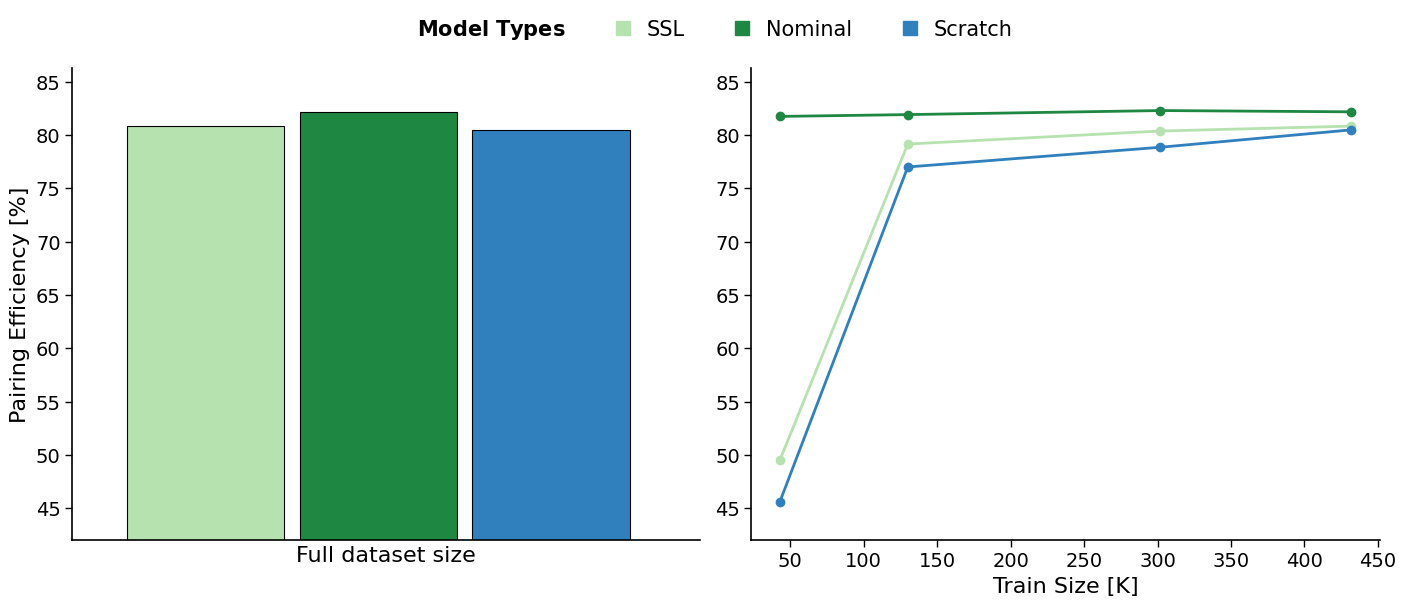

(<Figure size 1400x600 with 2 Axes>,
 <Axes: xlabel='Full dataset size', ylabel='Pairing Efficiency [%]'>,
 <Axes: xlabel='Train Size [K]'>)

In [127]:
plot_two_panel_QE_style(
    data_dict=data["pairing"],
    model_order=["SSL", "Nominal", "Scratch", "Ref."],
    model_colors=MODEL_COLORS,
    model_pretty_names=QE_PRETTY,
    y_label="Pairing Efficiency [%]",
    head_label="Assg + SG",
    ymin=42,
    panel_ratio=(2, 2),           # << tunable left:right panel ratio
    bar_margin=10.0,             # << bars closer to boundary
    bar_width=5.0,              # << slimmer bars
    bar_spacing=5.5,
    xrange=[2.5, 1.5], # << small gap between bars,
    plotdir="plot/QE",
    fname="pair.pdf"
)

Saved figure → deltaD.pdf


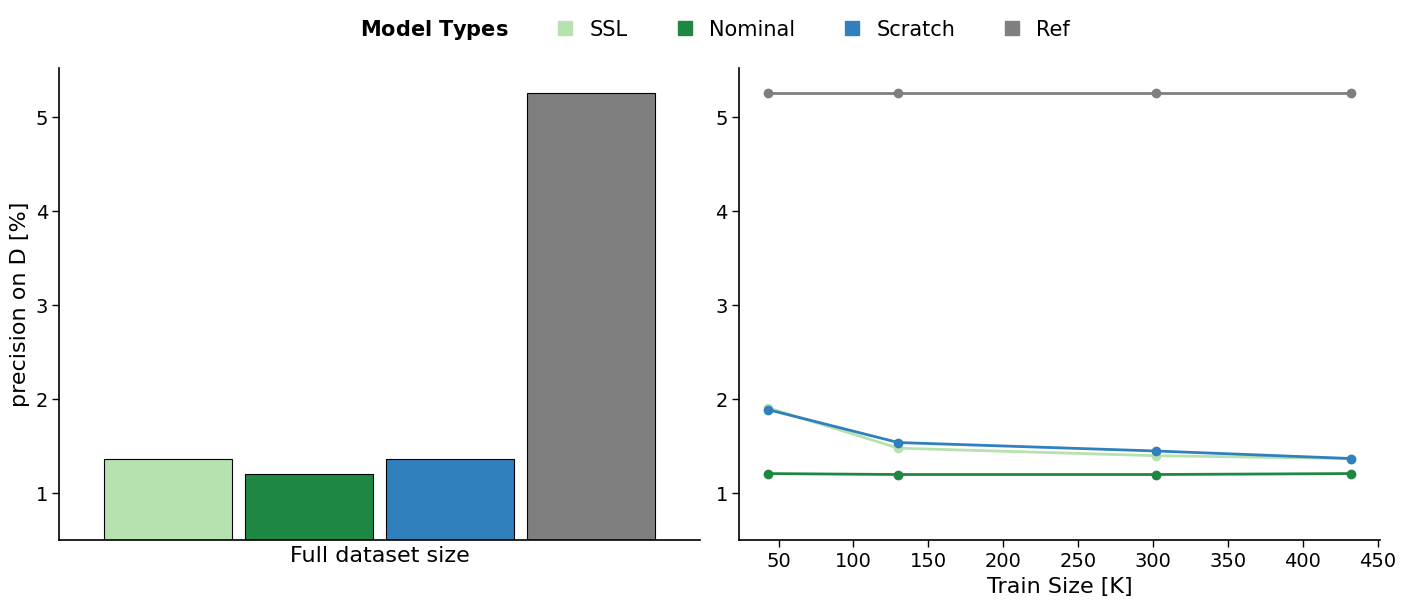

In [129]:
QE_performance = plot_two_panel_QE_style(
    data_dict=data["deltaD"],
    model_order=["SSL", "Nominal", "Scratch", "Ref."],
    model_colors=MODEL_COLORS,
    model_pretty_names=QE_PRETTY,
    y_label=r"precision on D [%]",
    head_label="Assg + SG",
    ymin=.5,
    panel_ratio=(2, 2),           # << tunable left:right panel ratio
    bar_margin=10.0,             # << bars closer to boundary
    bar_width=5.0,              # << slimmer bars
    bar_spacing=5.5,
    xrange=[2.5, 2.5],# << small gap between bars
    logy=False,
    plotdir="plot/QE",
    fname="deltaD.pdf"
)